<a href="https://colab.research.google.com/github/nravinuthala/EVA4.0/blob/master/S7_Nagaraj_Work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Changes to be made
1. change the code such that it uses GPU -- Done
2. change the architecture to C1C2C3C40 (basically 3 MPs) -- Done
3. total RF must be more than 44 -- Done
4. one of the layers must use Depthwise Separable Convolution -- Done
5. one of the layers must use Dilated Convolution -- Done
6. use GAP (compulsory):- add FC after GAP to target #of classes (optional) -- Done
7. achieve 80% accuracy, as many epochs as you want. Total Params to be less than 1M. -- Done
8. upload to Github -- Done
9. Attempt S7-Assignment Solution -- Done

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

from google.colab import drive
import sys

import matplotlib.pyplot as plt
import numpy as np

import cifar10_data_provider
%matplotlib inline
from matplotlib import pyplot as plt

In [0]:
#%load_ext autoreload
#%autoreload 2
#drive.mount('/content/gdrive')
#sys.path.append('/content/gdrive/My Drive/libs')
#import cifar10_data_provider
#cifar10_data_provider.transform_load()

In [79]:
transform = transforms.Compose(
    [
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
     ])

train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [81]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
    
# For reproducibility
torch.manual_seed(SEED)
    
if cuda:
  torch.cuda.manual_seed(SEED)
    
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
    
# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
    
# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane   cat   dog plane


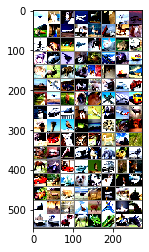

In [84]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:
import torch.nn as nn
import torch.nn.functional as F
#input size [3, 32, 32]
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # input size 32 output_size 32 rf 3
        
        #C1
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # input size 32 output_size 32 rf 5
        
        #T1
        self.pool1 = nn.MaxPool2d(2, 2)
        # input size 32 output_size 16 rf 6
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # input size 16 output_size 16 rf 6

        #C2
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # input size 16 output_size 16 rf 10
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # input size 16 output_size 16 rf 14

        #T2
        self.pool2 = nn.MaxPool2d(2, 2)
        # input size 16 output_size 8 rf 16
        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=(1, 1), padding=0, dilation=2, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # input size 8 output_size 8 rf 16

        #C3
        self.conv7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # input size 8 output_size 8 rf 24
        #self.conv8 = nn.Sequential(
        #    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
        self.conv8_1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(1, 3), padding=1, groups=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # input size 8 output_size 8 rf 32
        self.conv8_2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 1), padding=1, groups=128, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )# input size 8 output_size 8 rf 32
        #T3
        self.pool3 = nn.MaxPool2d(2, 2)
        # input size 8 output_size 4 rf 36
        self.conv9 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # input size 4 output_size 4 rf 36

        #C4
        self.conv10 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # input size 4 output_size 4 rf 52
      

        #Output block
        #GAP
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        )
        #self.fc = nn.Linear(64, 10, bias=False)
        #self.fc = nn.Linear(64*4*1, 10, bias=False)
        self.conv11 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        )
        

    def forward(self, x):
      x = self.conv1(x)
      x = self.conv2(x)
      x = self.pool1(x)
      x = self.conv3(x)
      x = self.conv4(x)
      x = self.conv5(x)
      x = self.pool2(x)
      x = self.conv6(x)
      x = self.conv7(x)
      x = self.conv8_1(x)
      x = self.conv8_2(x)
      x = self.pool3(x)
      x = self.conv9(x)
      x = self.conv10(x)
      x = self.gap(x)
      #x = self.fc(x)
      x = self.conv11(x)
      x = x.view(-1, 10)
      return F.log_softmax(x, dim=-1)

In [86]:
!pip install torchsummary
from torchsummary import summary

In [89]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)

cuda


In [90]:
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,608
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
           Dropout-8           [-1, 32, 32, 32]               0
         MaxPool2d-9           [-1, 32, 16, 16]               0
           Conv2d-10           [-1, 16, 16, 16]             512
      BatchNorm2d-11           [-1, 16, 16, 16]              32
             ReLU-12           [-1, 16, 16, 16]               0
          Dropout-13           [-1, 16, 16, 16]               0
           Conv2d-14           [-1, 32,

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [93]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=4, gamma=0.1)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.4239529371261597 Batch_id=390 Accuracy=37.56: 100%|██████████| 391/391 [00:12<00:00, 32.54it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.6926, Accuracy: 4072/10000 (40.72%)

EPOCH: 1


Loss=1.465264081954956 Batch_id=390 Accuracy=54.48: 100%|██████████| 391/391 [00:11<00:00, 39.80it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.6438, Accuracy: 4300/10000 (43.00%)

EPOCH: 2


Loss=1.003841519355774 Batch_id=390 Accuracy=61.01: 100%|██████████| 391/391 [00:12<00:00, 32.57it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.2052, Accuracy: 5693/10000 (56.93%)

EPOCH: 3


Loss=0.8556556701660156 Batch_id=390 Accuracy=64.23: 100%|██████████| 391/391 [00:11<00:00, 33.27it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.2106, Accuracy: 5779/10000 (57.79%)

EPOCH: 4


Loss=0.924640953540802 Batch_id=390 Accuracy=66.61: 100%|██████████| 391/391 [00:11<00:00, 33.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.0609, Accuracy: 6243/10000 (62.43%)

EPOCH: 5


Loss=0.7595756649971008 Batch_id=390 Accuracy=68.72: 100%|██████████| 391/391 [00:11<00:00, 33.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.9239, Accuracy: 6786/10000 (67.86%)

EPOCH: 6


Loss=0.7915351390838623 Batch_id=390 Accuracy=70.20: 100%|██████████| 391/391 [00:12<00:00, 32.54it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.9617, Accuracy: 6634/10000 (66.34%)

EPOCH: 7


Loss=0.6353105902671814 Batch_id=390 Accuracy=71.17: 100%|██████████| 391/391 [00:12<00:00, 31.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.0223, Accuracy: 6612/10000 (66.12%)

EPOCH: 8


Loss=0.7069243788719177 Batch_id=390 Accuracy=72.66: 100%|██████████| 391/391 [00:11<00:00, 33.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.9479, Accuracy: 6714/10000 (67.14%)

EPOCH: 9


Loss=0.6503170728683472 Batch_id=390 Accuracy=73.24: 100%|██████████| 391/391 [00:12<00:00, 32.37it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.9159, Accuracy: 6823/10000 (68.23%)

EPOCH: 10


Loss=0.7945936918258667 Batch_id=390 Accuracy=74.13: 100%|██████████| 391/391 [00:12<00:00, 32.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8306, Accuracy: 7091/10000 (70.91%)

EPOCH: 11


Loss=0.5370576977729797 Batch_id=390 Accuracy=75.18: 100%|██████████| 391/391 [00:12<00:00, 31.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7354, Accuracy: 7449/10000 (74.49%)

EPOCH: 12


Loss=0.6674295663833618 Batch_id=390 Accuracy=75.38: 100%|██████████| 391/391 [00:11<00:00, 33.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8792, Accuracy: 6992/10000 (69.92%)

EPOCH: 13


Loss=0.5638197660446167 Batch_id=390 Accuracy=75.94: 100%|██████████| 391/391 [00:12<00:00, 32.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7451, Accuracy: 7432/10000 (74.32%)

EPOCH: 14


Loss=0.8876262903213501 Batch_id=390 Accuracy=76.62: 100%|██████████| 391/391 [00:11<00:00, 40.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7110, Accuracy: 7524/10000 (75.24%)

EPOCH: 15


Loss=0.6383988857269287 Batch_id=390 Accuracy=76.96: 100%|██████████| 391/391 [00:12<00:00, 32.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8083, Accuracy: 7086/10000 (70.86%)

EPOCH: 16


Loss=0.8389579653739929 Batch_id=390 Accuracy=77.28: 100%|██████████| 391/391 [00:12<00:00, 32.30it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7080, Accuracy: 7548/10000 (75.48%)

EPOCH: 17


Loss=0.5570548176765442 Batch_id=390 Accuracy=77.67: 100%|██████████| 391/391 [00:11<00:00, 33.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6320, Accuracy: 7815/10000 (78.15%)

EPOCH: 18


Loss=0.5742214322090149 Batch_id=390 Accuracy=78.18: 100%|██████████| 391/391 [00:12<00:00, 32.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6836, Accuracy: 7632/10000 (76.32%)

EPOCH: 19


Loss=0.5055205225944519 Batch_id=390 Accuracy=78.23: 100%|██████████| 391/391 [00:12<00:00, 31.64it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6810, Accuracy: 7609/10000 (76.09%)

EPOCH: 20


Loss=0.5971026420593262 Batch_id=390 Accuracy=78.62: 100%|██████████| 391/391 [00:12<00:00, 31.45it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6503, Accuracy: 7761/10000 (77.61%)

EPOCH: 21


Loss=0.5182082653045654 Batch_id=390 Accuracy=78.74: 100%|██████████| 391/391 [00:11<00:00, 32.63it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6700, Accuracy: 7644/10000 (76.44%)

EPOCH: 22


Loss=0.48068323731422424 Batch_id=390 Accuracy=78.84: 100%|██████████| 391/391 [00:12<00:00, 31.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6413, Accuracy: 7795/10000 (77.95%)

EPOCH: 23


Loss=0.5843204259872437 Batch_id=390 Accuracy=79.10: 100%|██████████| 391/391 [00:12<00:00, 32.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7637, Accuracy: 7426/10000 (74.26%)

EPOCH: 24


Loss=0.5419872999191284 Batch_id=390 Accuracy=79.59: 100%|██████████| 391/391 [00:12<00:00, 31.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6406, Accuracy: 7782/10000 (77.82%)

EPOCH: 25


Loss=0.5986097455024719 Batch_id=390 Accuracy=79.73: 100%|██████████| 391/391 [00:11<00:00, 39.21it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6061, Accuracy: 7915/10000 (79.15%)

EPOCH: 26


Loss=0.5279577374458313 Batch_id=390 Accuracy=80.03: 100%|██████████| 391/391 [00:12<00:00, 32.28it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5825, Accuracy: 7981/10000 (79.81%)

EPOCH: 27


Loss=0.5332701206207275 Batch_id=390 Accuracy=80.18: 100%|██████████| 391/391 [00:12<00:00, 32.44it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6403, Accuracy: 7737/10000 (77.37%)

EPOCH: 28


Loss=0.5330516695976257 Batch_id=390 Accuracy=80.32: 100%|██████████| 391/391 [00:12<00:00, 31.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5951, Accuracy: 7928/10000 (79.28%)

EPOCH: 29


Loss=0.42006707191467285 Batch_id=390 Accuracy=80.57: 100%|██████████| 391/391 [00:12<00:00, 32.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5992, Accuracy: 7962/10000 (79.62%)

EPOCH: 30


Loss=0.5270248055458069 Batch_id=390 Accuracy=80.76: 100%|██████████| 391/391 [00:12<00:00, 32.49it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6718, Accuracy: 7673/10000 (76.73%)

EPOCH: 31


Loss=0.5843340754508972 Batch_id=390 Accuracy=80.73: 100%|██████████| 391/391 [00:11<00:00, 32.79it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5821, Accuracy: 8005/10000 (80.05%)

EPOCH: 32


Loss=0.6423360109329224 Batch_id=390 Accuracy=81.01: 100%|██████████| 391/391 [00:12<00:00, 31.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5835, Accuracy: 7996/10000 (79.96%)

EPOCH: 33


Loss=0.493710458278656 Batch_id=390 Accuracy=81.04: 100%|██████████| 391/391 [00:12<00:00, 32.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5675, Accuracy: 8040/10000 (80.40%)

EPOCH: 34


Loss=0.4630112051963806 Batch_id=390 Accuracy=81.12: 100%|██████████| 391/391 [00:11<00:00, 32.69it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5564, Accuracy: 8106/10000 (81.06%)

EPOCH: 35


Loss=0.5779206156730652 Batch_id=390 Accuracy=81.25: 100%|██████████| 391/391 [00:12<00:00, 32.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5611, Accuracy: 8086/10000 (80.86%)

EPOCH: 36


Loss=0.30638498067855835 Batch_id=390 Accuracy=81.28: 100%|██████████| 391/391 [00:12<00:00, 32.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5840, Accuracy: 8028/10000 (80.28%)

EPOCH: 37


Loss=0.6251574754714966 Batch_id=390 Accuracy=81.66: 100%|██████████| 391/391 [00:11<00:00, 32.61it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5549, Accuracy: 8117/10000 (81.17%)

EPOCH: 38


Loss=0.6226159334182739 Batch_id=390 Accuracy=81.50: 100%|██████████| 391/391 [00:11<00:00, 33.65it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5411, Accuracy: 8132/10000 (81.32%)

EPOCH: 39


Loss=0.46283745765686035 Batch_id=390 Accuracy=81.73: 100%|██████████| 391/391 [00:11<00:00, 32.72it/s]



Test set: Average loss: 0.5730, Accuracy: 8013/10000 (80.13%)



Text(0.5, 1.0, 'Test Accuracy')

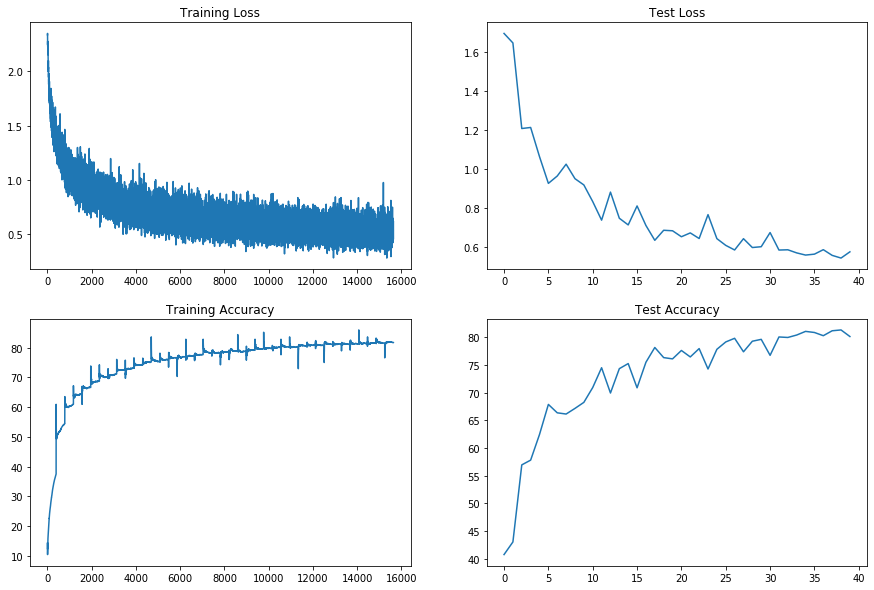

In [94]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")